In [ ]:
#!pip install -q tensorflow==2.1

     |████████████████████████████████| 421.8MB 25kB/s 
     |████████████████████████████████| 3.9MB 33.1MB/s 
     |████████████████████████████████| 450kB 43.1MB/s 


In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

print(tf.__version__)

2.8.0


In [2]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-8e0380e7-851e-bb10-0e9d-8cc5a8dddfb1)


## Load and preprocess MNIST dataset

In [4]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = (train_x.reshape(-1, 28*28).astype(np.float32) - 127.5) / 127.5

print(train_x.shape, train_x.dtype)
print(np.min(train_x), np.max(train_x))

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784) float32
-1.0 1.0


## Draw MNIST examples

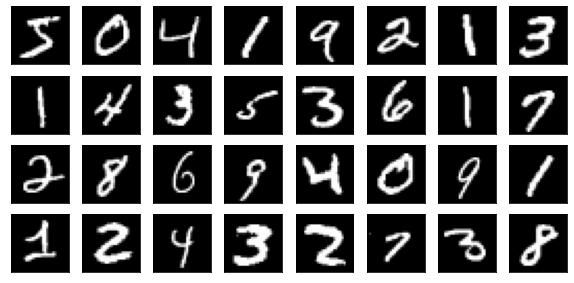

In [5]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train_x[:32, ...])

## Create GAN parts: Generator and Discriminator

In [6]:
generator = M.Sequential([
    L.Dense(256),
    L.LeakyReLU(0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(512),
    L.LeakyReLU(0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(1024),
    L.LeakyReLU(0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(784, activation='tanh'),
])

discriminator = M.Sequential([
    L.Dense(784, activation=None),
    L.LeakyReLU(alpha=0.2),
    L.Dense(392, activation=None),
    L.LeakyReLU(alpha=0.2),
    L.Dense(1, activation=None),
])

## Training parameters, dataset pipeline, optimizer

In [7]:
INPUT_DIM = 100
NUM_EPOCHS = 5
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## GAN training

[Step  0] D Loss: 0.6023; G Loss: 0.5665


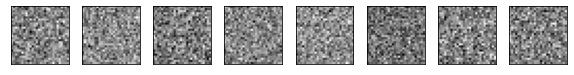

[Step 500] D Loss: 0.0637; G Loss: 6.3548


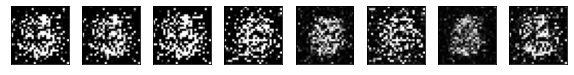

[Step 1000] D Loss: 0.1995; G Loss: 2.5470


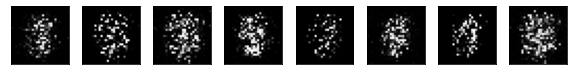

[Step 1500] D Loss: 0.2774; G Loss: 2.1066


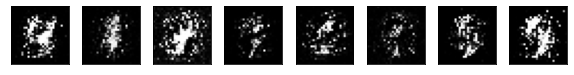

[Step 2000] D Loss: 0.5064; G Loss: 2.1807


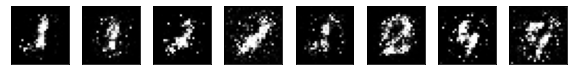

[Step 2500] D Loss: 0.4242; G Loss: 3.4108


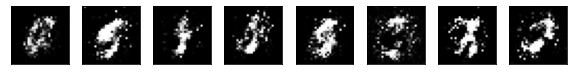

[Step 3000] D Loss: 0.5987; G Loss: 0.7669


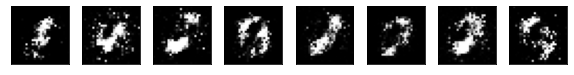

[Step 3500] D Loss: 0.5636; G Loss: 1.7064


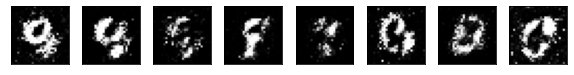

[Step 4000] D Loss: 0.4780; G Loss: 1.4413


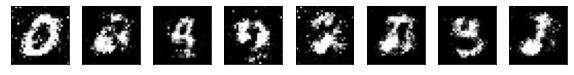

[Step 4500] D Loss: 0.5450; G Loss: 1.1095


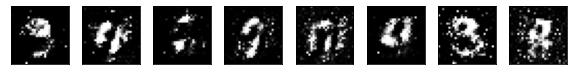

[Step 5000] D Loss: 0.5755; G Loss: 1.2575


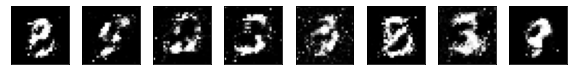

[Step 5500] D Loss: 0.5961; G Loss: 1.7679


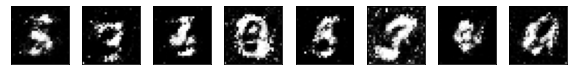

[Step 6000] D Loss: 0.5163; G Loss: 0.8042


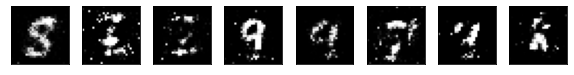

[Step 6500] D Loss: 0.5004; G Loss: 1.7919


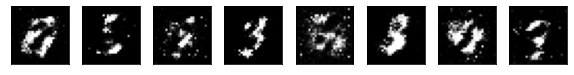

[Step 7000] D Loss: 0.5535; G Loss: 1.6338


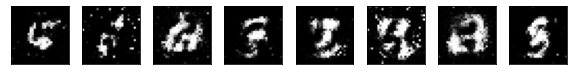

[Step 7500] D Loss: 0.7040; G Loss: 1.7685


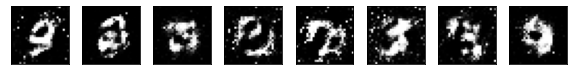

[Step 8000] D Loss: 0.4411; G Loss: 2.4475


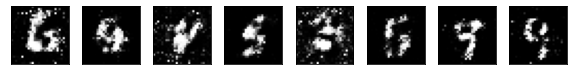

[Step 8500] D Loss: 0.9171; G Loss: 1.2190


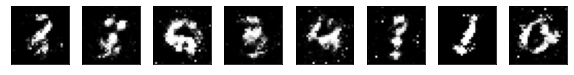

[Step 9000] D Loss: 0.5209; G Loss: 1.4146


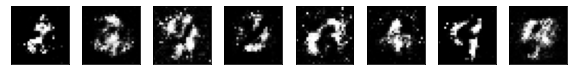

[Step 9500] D Loss: 0.5606; G Loss: 0.7255


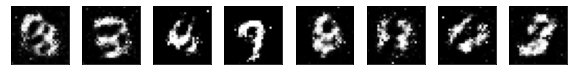

[Step 10000] D Loss: 0.7276; G Loss: 1.2652


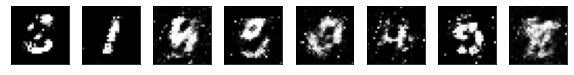

[Step 10500] D Loss: 0.5709; G Loss: 1.9983


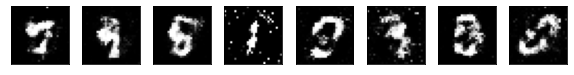

[Step 11000] D Loss: 0.4746; G Loss: 0.9050


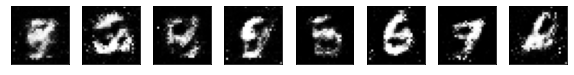

[Step 11500] D Loss: 0.4676; G Loss: 1.3796


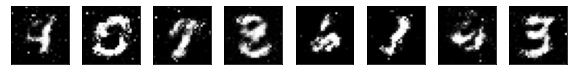

[Step 12000] D Loss: 0.5737; G Loss: 2.2968


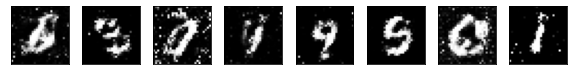

[Step 12500] D Loss: 0.6130; G Loss: 0.9362


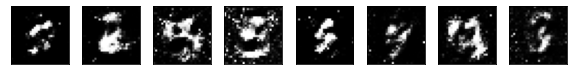

[Step 13000] D Loss: 0.5960; G Loss: 1.0854


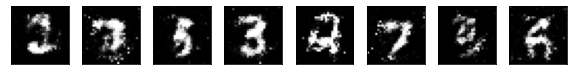

[Step 13500] D Loss: 0.3996; G Loss: 1.3696


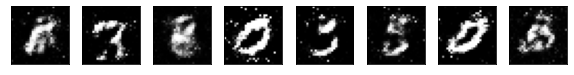

[Step 14000] D Loss: 0.5742; G Loss: 1.2359


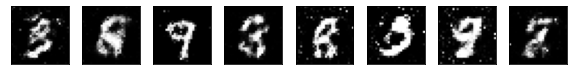

[Step 14500] D Loss: 0.6765; G Loss: 0.6635


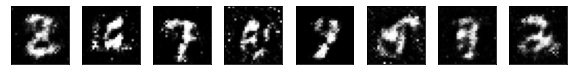

[Step 15000] D Loss: 0.6115; G Loss: 1.4616


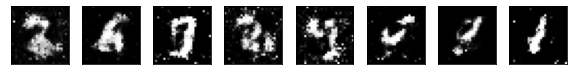

[Step 15500] D Loss: 0.5671; G Loss: 1.5848


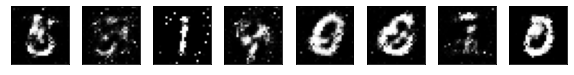

[Step 16000] D Loss: 0.7106; G Loss: 0.9668


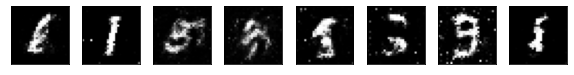

[Step 16500] D Loss: 0.4677; G Loss: 1.5223


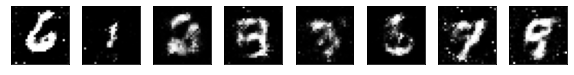

[Step 17000] D Loss: 0.3770; G Loss: 2.1332


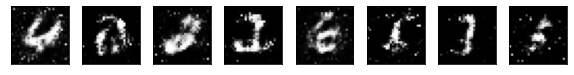

[Step 17500] D Loss: 0.5109; G Loss: 1.0941


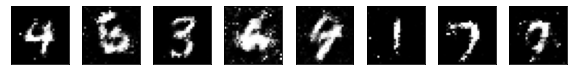

[Step 18000] D Loss: 0.6351; G Loss: 1.1273


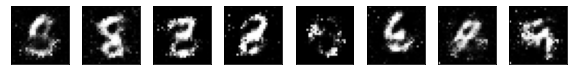

[Step 18500] D Loss: 0.5686; G Loss: 1.1327


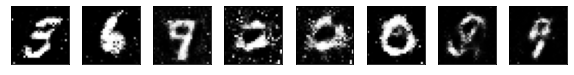

In [8]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1)), 
        np.zeros((HALF_BATCH_SIZE, 1))))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined)
        d_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1))
    
    with tf.GradientTape() as tape:
        logits = discriminator(generator(noise, training=True))
        g_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 500 == 0:
        print("[Step %2d] D Loss: %.4f; G Loss: %.4f" % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)


## Generator test: random examples

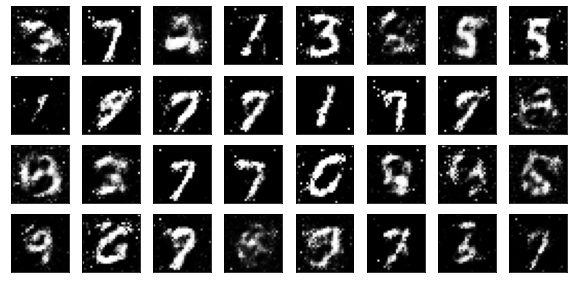

In [9]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Generator test: continuous examples

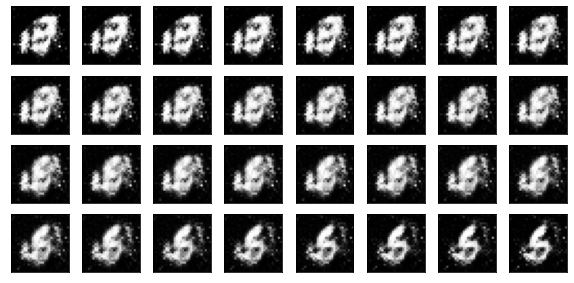

In [10]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Deep Convolutional GAN (DCGAN)

In [11]:
generator = M.Sequential([
    L.Dense(128*7*7, activation="relu"),
    L.Reshape((7, 7, 128)),
    L.UpSampling2D((2, 2)),    
    L.Conv2D(128, (3, 3), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.ReLU(),    
    L.UpSampling2D((2, 2)),    
    L.Conv2D(64, (3, 3), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.ReLU(),    
    L.Conv2D(1, (3, 3), padding="same", activation='tanh'),
])

discriminator = M.Sequential([
    L.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
    L.LeakyReLU(0.2),
    L.Dropout(0.25),    
    L.Conv2D(64, kernel_size=3, strides=(2, 2), padding="same"),
    L.ZeroPadding2D(padding=((0, 1), (0, 1))),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Conv2D(128, kernel_size=3, strides=(2, 2), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Conv2D(256, kernel_size=3, strides=(1, 1), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Flatten(),
    L.Dense(1, activation=None),
])

## Training parameters, dataset pipeline, optimizer

In [12]:
INPUT_DIM = 100
NUM_EPOCHS = 2
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x.reshape(-1, 28, 28, 1))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## DCGAN training

[Step  0] D Loss: 0.8590; G Loss: 0.6898


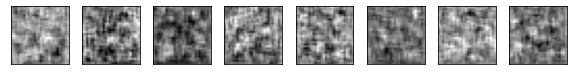

[Step 200] D Loss: 1.8299; G Loss: 1.9228


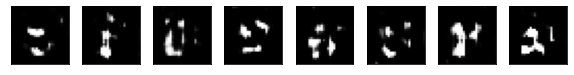

[Step 400] D Loss: 0.7052; G Loss: 1.3075


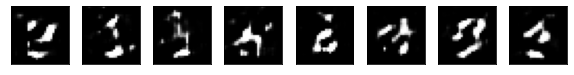

[Step 600] D Loss: 0.8018; G Loss: 1.0228


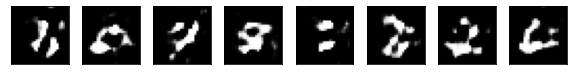

[Step 800] D Loss: 0.6649; G Loss: 0.8419


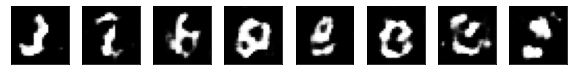

[Step 1000] D Loss: 0.5523; G Loss: 0.9327


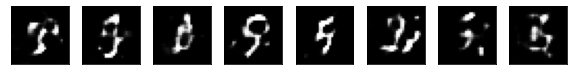

[Step 1200] D Loss: 0.6098; G Loss: 1.1095


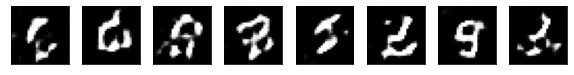

[Step 1400] D Loss: 0.5889; G Loss: 1.5220


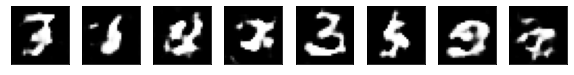

[Step 1600] D Loss: 0.6170; G Loss: 0.9863


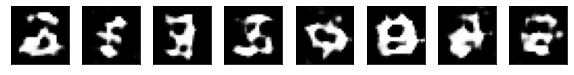

[Step 1800] D Loss: 0.7410; G Loss: 0.7462


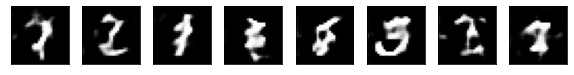

[Step 2000] D Loss: 0.5637; G Loss: 1.5845


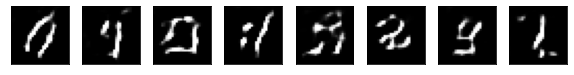

[Step 2200] D Loss: 0.8003; G Loss: 0.9264


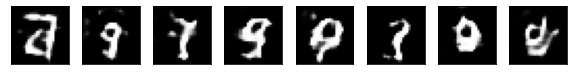

[Step 2400] D Loss: 0.7774; G Loss: 0.8555


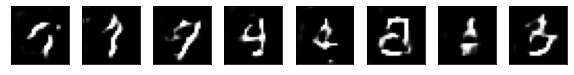

[Step 2600] D Loss: 0.6392; G Loss: 0.9445


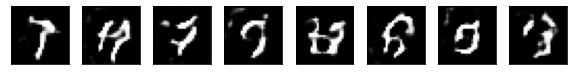

[Step 2800] D Loss: 0.7901; G Loss: 0.7961


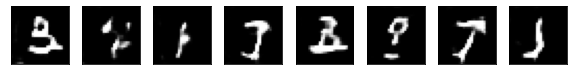

[Step 3000] D Loss: 0.5867; G Loss: 0.8429


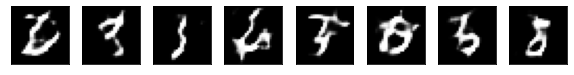

[Step 3200] D Loss: 0.7101; G Loss: 0.8509


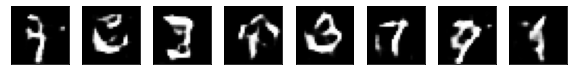

[Step 3400] D Loss: 0.8202; G Loss: 0.7850


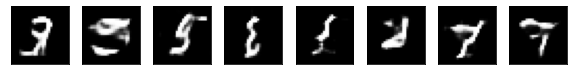

[Step 3600] D Loss: 0.6611; G Loss: 0.8743


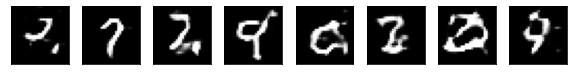

[Step 3800] D Loss: 0.7437; G Loss: 0.8076


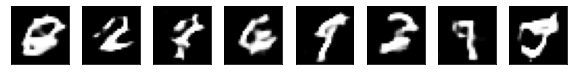

[Step 4000] D Loss: 0.8495; G Loss: 0.8609


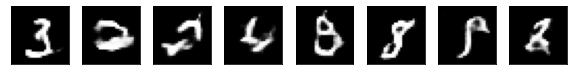

[Step 4200] D Loss: 0.6640; G Loss: 0.9523


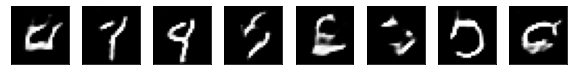

[Step 4400] D Loss: 0.7433; G Loss: 0.8016


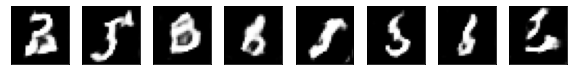

[Step 4600] D Loss: 0.6562; G Loss: 0.7937


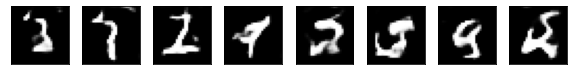

[Step 4800] D Loss: 0.6179; G Loss: 0.8492


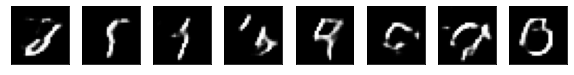

[Step 5000] D Loss: 0.7527; G Loss: 0.6714


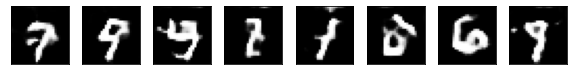

[Step 5200] D Loss: 0.6639; G Loss: 0.8917


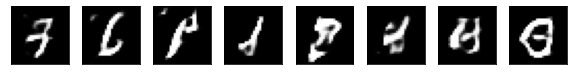

[Step 5400] D Loss: 0.6840; G Loss: 0.7661


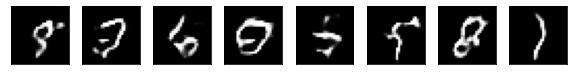

[Step 5600] D Loss: 0.8424; G Loss: 1.0416


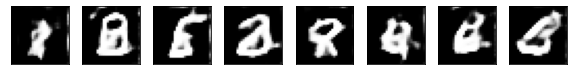

[Step 5800] D Loss: 0.6221; G Loss: 0.8957


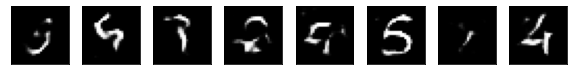

[Step 6000] D Loss: 0.6384; G Loss: 0.8342


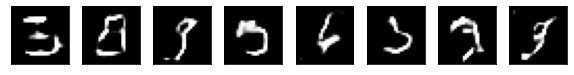

[Step 6200] D Loss: 0.7610; G Loss: 0.8939


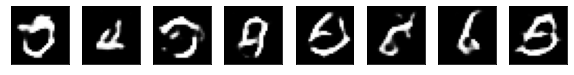

[Step 6400] D Loss: 0.7143; G Loss: 0.7001


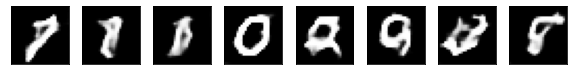

[Step 6600] D Loss: 0.6974; G Loss: 0.6601


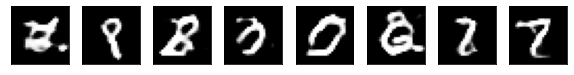

[Step 6800] D Loss: 0.7188; G Loss: 0.7455


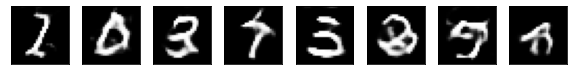

[Step 7000] D Loss: 0.7446; G Loss: 0.7147


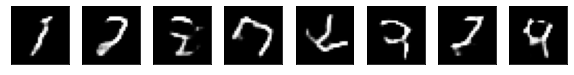

[Step 7200] D Loss: 0.6642; G Loss: 0.8218


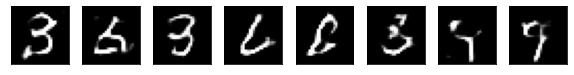

[Step 7400] D Loss: 0.7692; G Loss: 0.8592


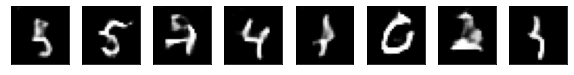

In [13]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1)), 
        np.zeros((HALF_BATCH_SIZE, 1))))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1))
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 200 == 0:
        print("[Step %2d] D Loss: %.4f; G Loss: %.4f" % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)


## Generator test: random examples

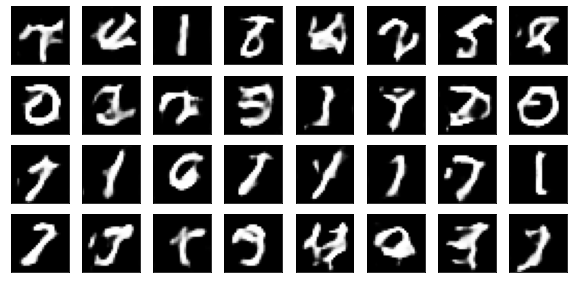

In [14]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Generator test: continuous examples

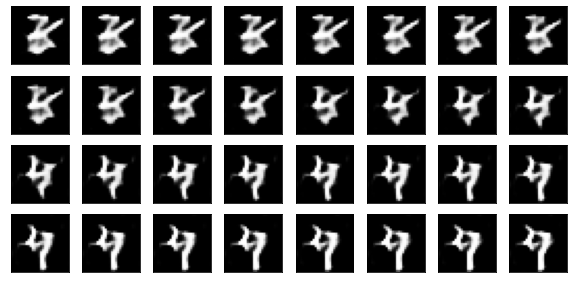

In [15]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

In [ ]:
# больше примеров можно найти тут https://github.com/eriklindernoren/Keras-GAN